<a href="https://colab.research.google.com/github/Ashi743/ML-practices/blob/main/boruta_feat_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-cancer-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1829286%2F2984728%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240901%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240901T131100Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D57e5a99fdc95bdbbba630f090d5a6edb166e1833fe4ec3b438920ed527518f159971419122de0ca74f6e4851ab46eaabf16f56cb9efd17e5cca37a29e1e5507c2efd6d480f2c35185edc694d9c76b2eeafe51c3b391c3fb42e58c0a34c88f7470bbd7cee0613c1119d014ba83c8076073dc36b6fb9c8c24fb0e4e3bd07faf1d451bfaca364b0b28ec7fec6380827f1eef5d26ed2eb1621ded9d951e0b62ee82f0e18b4cde0286e47ec910a88d0d976228549b9477bfa2417ebaf915515b8db8be5b778ef3243c50abaa8e9134eb1cdffd69cafa9c8fdd80955679c8b2d4a5c597e9bb9d5acc49fc6b59cdb3560391c25a6d25483c995a780e157e2e3c75746cf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-dataset/breast-cancer.csv


In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df= pd.read_csv("/kaggle/input/breast-cancer-dataset/breast-cancer.csv")

In [ ]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
df.drop(columns= ["id"], inplace=True)

In [ ]:
X= df.drop(columns=["diagnosis"])
Y= pd.DataFrame(df["diagnosis"])

In [ ]:
X

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

In [ ]:
X.shape

(569, 30)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
Y_le= le.fit_transform(Y)
Y_le

from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(X)
X= ss.transform(X)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,  f_classif
from sklearn.metrics import accuracy_score

In [ ]:
X_train, X_test,Y_train, Y_test= train_test_split(X,Y_le)

In [ ]:
selector = SelectKBest(score_func=f_classif, k=9)  # Here, k=2 means selecting the top 2 features

X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train_selected, Y_train)

y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy with selected features: {accuracy:.2f}")

selected_features = selector.get_support(indices=True)

Accuracy with selected features: 0.93


In [ ]:
selected_features

array([ 0,  2,  3,  6,  7, 20, 22, 23, 27])

In [ ]:
pd.DataFrame(X_test_selected, columns= selected_features)

,0,2,3,6,7,20,22,23,27
0,0.449512,0.413178,0.303781,-0.219076,0.268537,0.254879,0.209656,0.074214,0.347072
1,-0.413892,-0.441519,-0.469246,-0.713993,-0.718340,-0.529963,-0.552861,-0.538243,-0.892069
2,-0.450813,-0.441519,-0.507926,-0.370614,-0.416035,-0.558955,-0.613327,-0.577620,-0.464354
3,0.398389,0.483201,0.256000,1.083503,0.904617,0.459891,0.567086,0.271451,1.321574
4,0.969258,0.952769,0.843876,0.185822,0.669634,0.859560,0.960259,0.630066,1.207374
...,...,...,...,...,...,...,...,...,...
138,0.446671,0.380225,0.317717,-0.287124,0.076630,0.795365,0.656444,0.682803,0.601356
139,-0.584300,-0.582390,-0.596377,-0.640169,-0.540104,-0.583805,-0.605880,-0.581312,-0.619360
140,-0.357089,-0.383029,-0.414355,-0.889260,-0.722725,-0.376722,-0.361040,-0.445953,-0.772997
141,0.264902,0.343154,0.144227,1.019472,1.011920,0.406050,0.483686,0.253872,1.475363


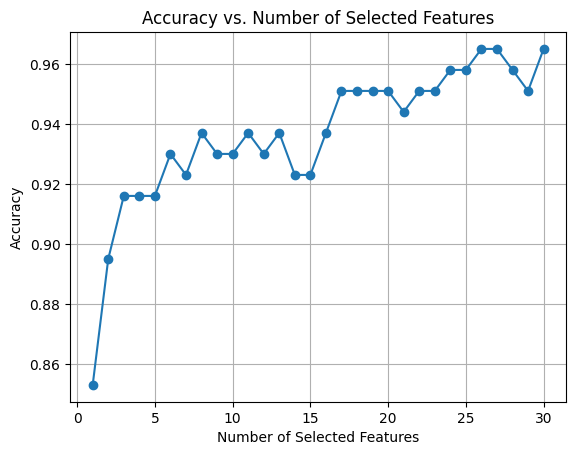

In [ ]:
import matplotlib.pyplot as plt
scores= []
for i in range(X.shape[1]):
    selector = SelectKBest(score_func=f_classif, k=i+1)  # Here, k=2 means selecting the top 2 features

    X_train_selected = selector.fit_transform(X_train, Y_train)
    X_test_selected = selector.transform(X_test)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, Y_train)

    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(Y_test, y_pred)
    scores.append(accuracy)
    #print(f"Accuracy with selected features: {accuracy:.2f}")

plt.plot(range(1, X.shape[1] + 1),scores, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Selected Features')
plt.grid(True)
plt.show()

***boruta***

In [ ]:
X= df.drop(columns=["diagnosis"])
Y= pd.DataFrame(df["diagnosis"])

from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
Y_le= le.fit_transform(Y)
Y_le

from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
ss.fit(X)
X_ss= ss.transform(X)

X_train, X_test,Y_train, Y_test= train_test_split(X_ss,Y_le)

In [ ]:
import xgboost as xgb
model= xgb.XGBClassifier()  #for boruta
from boruta import BorutaPy as Bpy
feat_selector= Bpy(model,n_estimators= 50 ,verbose= 2 )
feat_selector.fit(X_train, Y_train)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	18
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	18
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	18
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	7
Rejected: 	18
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	5
Rejected: 	20
I

BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=50,
                                 n_jobs=None, num_parallel_tree=None,
                                 random_state=945117914, ...),
         n_estimators=50, random_state=RandomState(MT19937) at 0x7C735C1CF240,
         verbose=2)

(569, 30)

In [ ]:
feature_names= X.columns

In [ ]:
dd = pd.DataFrame(feature_ranks, columns=["features", "rank", "bool"])

# Filter the DataFrame to find features with rank 1 and bool == True
selected_features = dd[(dd["rank"] == 1) & (dd["bool"] == True)]

# Print the selected features
print(selected_features["features"].tolist())

['concavity_mean', 'concave points_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [ ]:
column_names = X.columns
column_indices =  [ 0, 2, 3, 6, 7, 20, 22, 23, 27]
selected_column_names = [column_names[i] for i in column_indices]

# Print the result
print("Selected column names:", selected_column_names)

Selected column names: ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [ ]:
X_train_filtered= feat_selector.transform(X_train)
X_test_filtered= feat_selector.transform(X_test)

In [ ]:
xgb_model= xgb.XGBClassifier()
xgb_model.fit(X_train_filtered, Y_train)
p_pred= xgb_model.predict(X_test_filtered)
accuracy_score(Y_test, p_pred)

0.958041958041958

<Axes: >

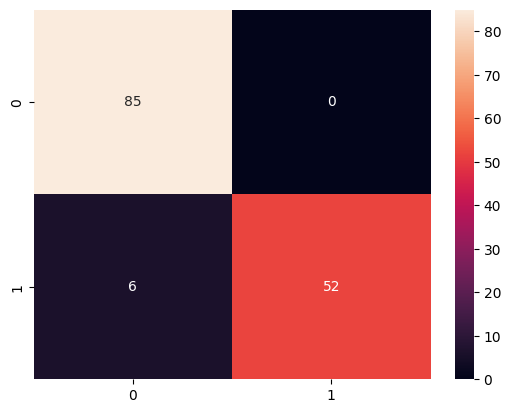

In [ ]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(Y_test, p_pred)
import seaborn as sns
sns.heatmap(cm ,annot=True)

concavity_mean, concave points_mean, radius_worst, texture_worst, perimeter_worst, area_worst, concave points_worst
'radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst'